# YIN pitch estimation algorithm
Python implementation of the YIN algorithm described on [this paper](http://audition.ens.fr/adc/pdf/2002_JASA_YIN.pdf). 

In [18]:
# ! pip install numpy scipy matplotlib tqdm IPython

In [2]:
from scipy import signal as sg
from scipy.io import wavfile
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

These are some functions that we are going to need later.

In [3]:
# This function takes in an array and finds the first local minima below a given threshold.
def find_first_local_min_below_threshold(array, threshold):
  local_minima_indices = sg.argrelmin(array)[0]
  for idx in local_minima_indices:
      if array[idx] < threshold:
          return idx
  return None

In [4]:
# This function performs the parabolic interpolation to find the exact x position of the local minima.
def parabolic_interp(prev, max, next):
    numerator = prev - next
    denominator = prev - 2 * max + next
    
    x_max = 0.5 * numerator / denominator
    
    return x_max

To test the algorithm I use [this sound](https://freesound.org/people/TheScarlettWitch89/sounds/427200/) from [freesound](https://freesound.org/).

In [ ]:
# Load the audio file and convert it to mono.
fs, audio = wavfile.read('Sounds/427200__thescarlettwitch89__female-ooh-singing-voice-cleaned-with-reverb-by-erokia.wav')
audio = audio[:,0]

This is what the input audio signal looks and sounds like:

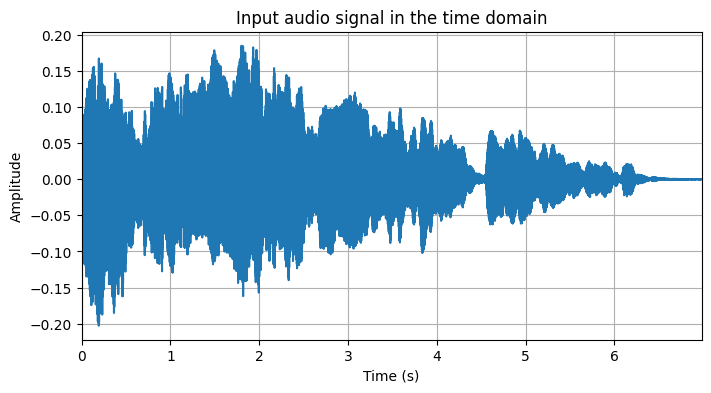

In [6]:
# Plot the audio file
plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(audio))/fs, audio)
plt.xlim(0, len(audio)/fs)
plt.grid(True)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Input audio signal in the time domain')

ipd.Audio(audio, rate=fs)

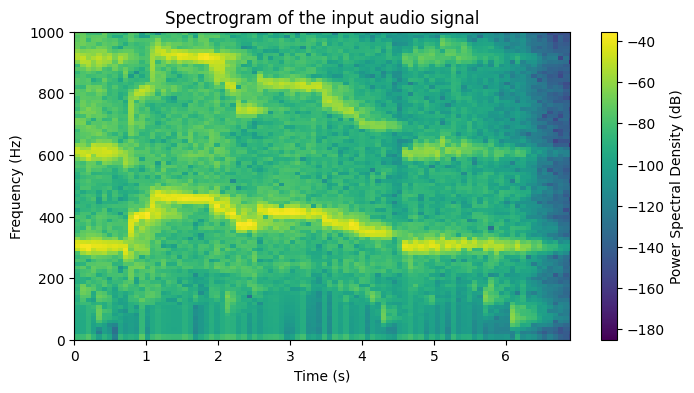

In [7]:
W = 2**12
window = sg.get_window('hamming', W)
frequencies, times, spectrogram = sg.spectrogram(audio, fs, window)
plt.figure(figsize=(8, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram of the input audio signal')
plt.colorbar(label='Power Spectral Density (dB)')
plt.ylim(0, 1000)
plt.xlim([0, (len(audio) - W)/fs])

ipd.Audio(audio, rate=fs)

This is what the input signal looks like upon closer inspection.

Text(0.5, 1.0, 'Segment of the audio signal in the time domain')

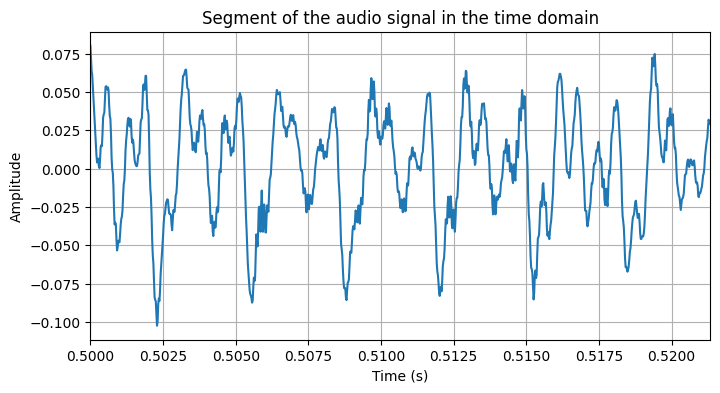

In [8]:
plt.figure(figsize=(8, 4))

# Plot of 1024 samples of the audio file
plt.plot(np.arange(fs//2, fs//2 + 1024)/fs, audio[fs//2 : fs//2 + 1024])
plt.xlim([fs//2/fs, (fs//2 + 1024)/fs])
plt.grid(True)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Segment of the audio signal in the time domain')

The `difference()` function below calculates the difference between the squared signal and its delayed version for all the possible delay values $\tau$.

**/!\ Warning:** Don't use `difference()` but `difference_vectorized()` instead. It is much faster and has the same functionality, I only kept this one because it's easier to understand.

In [9]:
def difference(x, W, max_tau):
  diff = [0] * (max_tau + 1)
  for tau in range(max_tau + 1):
    for j in range(1, W - tau):
      diff[tau] += (x[j] - x[j + tau])**2
  return diff

In [10]:
def difference_vectorized(x, W, max_tau):
    diff = np.zeros(max_tau + 1)
    for tau in range(max_tau + 1):
        diff[tau] = np.sum((x[:W-tau] - x[tau:W])**2)
    return diff

(0.0, 960.0)

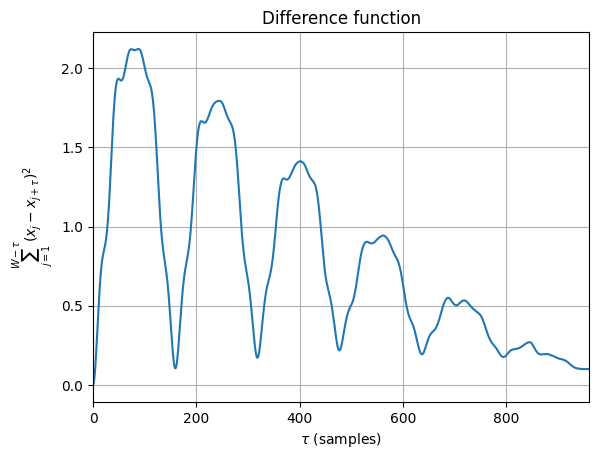

In [15]:
x = audio
max_tau = fs//50
plt.plot(difference_vectorized(x, 1024, max_tau))
plt.xlabel(r'$\tau$ (samples)')
plt.ylabel(r'$\sum_{j=1}^{W-\tau} (x_j - x_{j+\tau})^2$')
plt.title('Difference function')
plt.grid(True)
plt.xlim(0, max_tau)

The `computeCmndf()`  calculates the cmndf starting from the difference function.

**/!\ Warning:** Again, don't use the `computeCmndf()` function but `computeCmndf_vectorized()` instead.

In [12]:
# Function that calculates the cumulative mean normalized difference function.
def computeCmndf(x, W, min_tau, max_tau):
  cmndf = np.empty(max_tau - min_tau)
  diff = difference(x, W, max_tau)
  for tau in range(min_tau, max_tau):
    if tau == 0:
      cmndf[tau - min_tau] = 1.0
    else:
      sum = np.sum(diff[1:tau+1])
      cmndf[tau - min_tau] = diff[tau] / (sum / tau)
  return cmndf

In [13]:
def computeCmndf_vectorized(x, W, min_tau, max_tau):
    cmndf = np.empty(max_tau - min_tau)
    diff = difference(x, W, max_tau)
    if min_tau == 0:
        cmndf[1 : max_tau - min_tau + 1] = diff[1:max_tau] / (np.cumsum(diff[1:max_tau]) / np.arange(1, max_tau))
        cmndf[0] = 1.0
    else:
        cmndf[0 : max_tau - min_tau + 1] = diff[min_tau:max_tau] / (np.cumsum(diff[min_tau:max_tau]) / np.arange(min_tau, max_tau))
    return cmndf

Predicted tau: 159.15 samples
Predicted fundamental frequency: 301.61 Hz


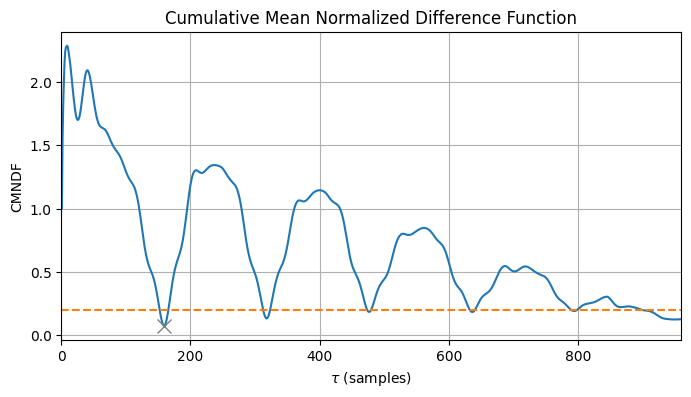

In [17]:
min_tau = 0
max_tau = fs//50
W = 1024

cmndf = computeCmndf_vectorized(audio, W, min_tau, max_tau)
cmndf_threshold = 0.2

plt.figure(figsize=(8, 4))
plt.plot(cmndf)
plt.xlabel(r'$\tau$ (samples)')
plt.ylabel('CMNDF')
plt.title('Cumulative Mean Normalized Difference Function')
plt.grid(True)
plt.xlim([0, max_tau - min_tau])

predicted_tau = find_first_local_min_below_threshold(cmndf, cmndf_threshold)
plt.axhline(y=cmndf_threshold, color='C1', linestyle='--')
plt.plot(predicted_tau, cmndf[predicted_tau], 'xC7', markersize=10)

interp_add = parabolic_interp(cmndf[predicted_tau - 1], cmndf[predicted_tau], cmndf[predicted_tau + 1])
f0 = fs / (predicted_tau + interp_add)

print(f'Predicted tau: {predicted_tau + interp_add:.2f} samples')
print(f'Predicted fundamental frequency: {f0:.2f} Hz')

The function `pitchDetect()` below is going to be the main function that allows to estimate the pitch of a given audio signal. Frame by frame, it computes the CMNDF of the frame and finds the first candidate to f0 (a local minima from the CMNDF function) that falls below the stablished threshold. Only the values of $\tau$ corresponding to frequencies between `min_f0` and `max_f0` are considered.

In [16]:

def pitchDetect(audio, fs, W, min_f0, max_f0, cmndf_threshold):
  res = []
  min_tau = fs // max_f0
  max_tau = fs // min_f0

  for start in tqdm(range(0, len(audio), W//2), desc="Pitch estimation"):
    x = audio[start:start+W]
    if (len(x) != W):
      break
    cmndf = computeCmndf(x, W, min_tau, max_tau)
    predicted_tau = find_first_local_min_below_threshold(cmndf, cmndf_threshold)
    if predicted_tau != None:
      interp_add = parabolic_interp(cmndf[predicted_tau - 1], cmndf[predicted_tau], cmndf[predicted_tau + 1])
      delay = min_tau + predicted_tau + interp_add
      f0 = fs / delay
      res.append(f0)
    else:
      res.append(None)
  return np.array(res)

Next, I tested the pitch estimation algorithm in the input audio signal. The resulting pitch envelope over the original spectrogram is included below.

In [ ]:
min_f0 = 90
max_f0 = 750
W = 2**12
cmndf_threshold = 0.2
f0 = pitchDetect(audio, fs, W, min_f0, max_f0, cmndf_threshold)

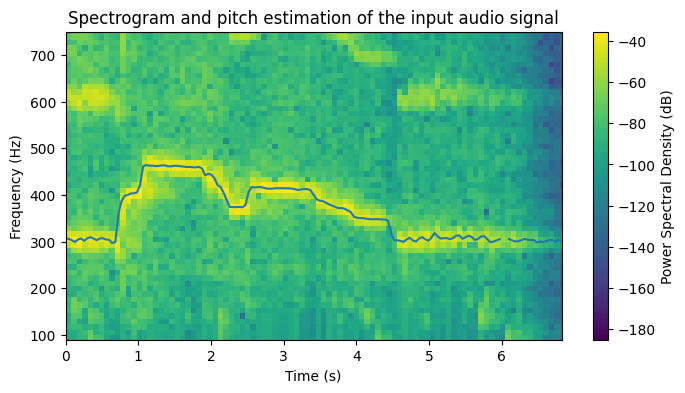

In [21]:
# Plot of the pitch estimation over the spectrogram
plt.rcParams.update({"axes.grid" : False})
frequencies, times, spectrogram = sg.spectrogram(audio, fs, window = window)
plt.figure(figsize=(8, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power Spectral Density (dB)')
plt.plot(np.arange(0, len(f0) * (W//2), (W//2))/fs, f0)
plt.ylim(min_f0, max_f0)
plt.xlim(0, (len(f0) - 2) * (W//2) / fs)

plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram and pitch estimation of the input audio signal')

ipd.Audio(audio, rate=fs)